In [1]:
from omegaconf import OmegaConf as om
from mosaicfm.model import ComposerSCGPTModel
from mosaicfm.tasks import get_batch_embeddings
from mosaicfm.tokenizer import GeneVocab
import torch
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
%matplotlib inline

/vevo/umair/miniforge3/envs/mosaicfm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_lisi_scores(emb, labels, k):
    nng = kneighbors_graph(emb, n_neighbors=k).tocoo()
    labels = pd.Categorical(labels).codes
    self_id = labels[nng.row]
    ne_id = labels[nng.col]

    _, c = np.unique(labels, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

In [3]:
model_paths = {
    "baseline": "/vevo/umair/data/scgpt-models/scgpt-70m-1024-fix-norm-apr24-data/best-model.pt",
    "constant-lr-10ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-constant-lr/ep10-ba70840-rank0.pt",
    "constant-lr-20ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-constant-lr/ep20-ba141680-rank0.pt",
    "constant-lr-30ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-constant-lr/ep30-ba212520-rank0.pt",
    "constant-lr-40ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-constant-lr/ep40-ba283360-rank0.pt",
    "constant-lr-50ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-constant-lr/ep50-ba354200-rank0.pt",
    "no-load-10ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-no-load/ep10-ba70840-rank0.pt",
    "no-load-20ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-no-load/ep20-ba141680-rank0.pt",
    "no-load-30ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-no-load/ep30-ba212520-rank0.pt",
    "no-load-40ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-no-load/ep40-ba283360-rank0.pt",
    "no-load-50ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-no-load/ep50-ba354200-rank0.pt",
    "mosaicfm-70m-tahoe": "/vevo/umair/data/scgpt-models/mosaicfm-70m-tahoe/best-model.pt" 
}

In [4]:
model_name = "mosaicfm-70m-tahoe"
dataset = "rif"

In [5]:
# load vocabulary
if model_name == "mosaicfm-70m-tahoe":
    vocab_path = "/vevo/umair/data/scgpt-models/mosaicfm-70m-tahoe/vocab.json"
else:
    vocab_path = "/vevo/umair/data/scgpt-models/scgpt-70m-1024-fix-norm-apr24-data/vocab.json"
vocab = GeneVocab.from_file(vocab_path)
vocab.set_default_index(vocab["<pad>"])

# set variables
if dataset == "lung":
    data_path = "/vevo/umair/data/benchmark-adaptation/lung.h5ad"
    if model_name == "mosaicfm-70m-tahoe":
        gene_col = "ensembl_id"
    else:
        gene_col = "gene_name"
    cell_type_key = "cell_type"
elif dataset == "rif":
    data_path = "/vevo/umair/data/benchmark-adaptation/rif.h5ad"
    if model_name == "mosaicfm-70m-tahoe":
        gene_col = "gene_id"
    else:
        gene_col = "feature_name"
    cell_type_key = "cell_line_orig"

# load data
adata = sc.read_h5ad(data_path)
adata.var["id_in_vocab"] = [vocab[gene] if gene in vocab else -1 for gene in adata.var[gene_col]]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
print(f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes in vocabulary of size {len(vocab)}.")
adata = adata[:, adata.var["id_in_vocab"] >= 0]
genes = adata.var[gene_col].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

match 37392/37476 genes in vocabulary of size 62720.


In [6]:
# only get cell embeddings if they don't already exist
if model_name not in adata.obsm_keys():

    # load model
    if model_name == "mosaicfm-70m-tahoe":
        model_config_path = "/vevo/umair/data/scgpt-models/mosaicfm-70m-tahoe/model_config.yml"
        collator_config_path = "/vevo/umair/data/scgpt-models/mosaicfm-70m-tahoe/collator_config.yml"
    else:
        model_config_path = "/vevo/umair/data/scgpt-models/scgpt-70m-1024-fix-norm-apr24-data/model_config.yml"
        collator_config_path = "/vevo/umair/data/scgpt-models/scgpt-70m-1024-fix-norm-apr24-data/collator_config.yml"
    model_file = model_paths[model_name]
    model_config = om.load(model_config_path)
    collator_config = om.load(collator_config_path)
    model = ComposerSCGPTModel(model_config = model_config, collator_config = collator_config)
    model.load_state_dict(torch.load(model_file)["state"]["model"], strict=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # get cell embeddings
    cell_embeddings = get_batch_embeddings(
        adata=adata,
        model=model.model,
        vocab=vocab,
        gene_ids=gene_ids,
        model_cfg=model_config,
        collator_cfg=collator_config,
        batch_size=256,
        max_length=2048,
        return_gene_embeddings=False
    )

    # add to AnnData and save
    adata.obsm[model_name] = cell_embeddings
    adata.write_h5ad(data_path)

Embedding cells: 100%|██████████| 100000/100000 [03:26<00:00, 484.89it/s]
/tmp/ipykernel_723707/709098029.py:34: ImplicitModificationWarning: Setting element `.obsm['mosaicfm-70m-tahoe']` of view, initializing view as actual.
  adata.obsm[model_name] = cell_embeddings


In [ ]:
# compute LISI score and plot
lisi_score = compute_lisi_scores(adata.obsm[model_name], adata.obs[cell_type_key].values, 20) 
print(f"{model_name} LISI:{lisi_score:.2f}")
# sc.pp.neighbors(adata, use_rep=model_name)
# sc.tl.umap(adata)
# fig = sc.pl.umap(adata, 
#     color=[cell_type_key], 
#     frameon=False, 
#     wspace=0.4, 
#     title=[f"{model_name} LISI:{lisi_score:.2f}"],
#     return_fig=True
# )

# plt.show()

no-load-10ep LISI:15.79


16.32962296801315


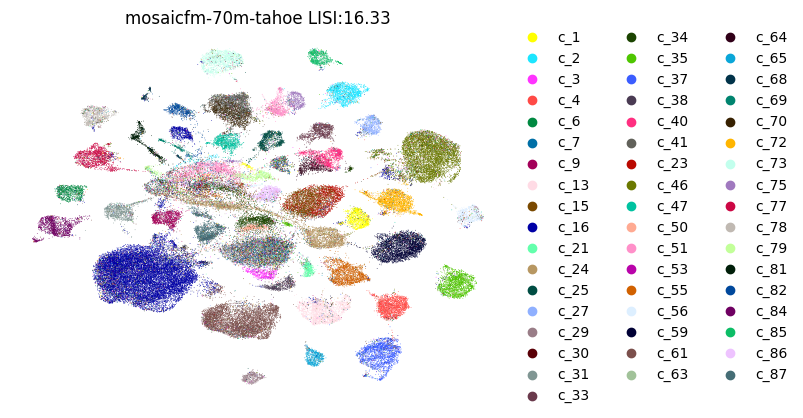

In [8]:
adata = sc.read_h5ad("/vevo/umair/data/benchmark-adaptation/rif.h5ad")
model_name = "mosaicfm-70m-tahoe"
cell_type_key = "cell_line_orig"
lisi_score = compute_lisi_scores(adata.obsm[model_name], adata.obs[cell_type_key].values, 20)
print(lisi_score)
sc.pp.neighbors(adata, use_rep=model_name)
sc.tl.umap(adata)
fig = sc.pl.umap(adata, 
    color=[cell_type_key], 
    frameon=False, 
    wspace=0.4, 
    title=[f"{model_name} LISI:{lisi_score:.2f}"],
    return_fig=True
)

plt.show()